In [1]:
# Group 5
# Neel Gandhi, Sunishka Jain, Daniel Shen, Julian Wu

# Imports
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler 

In [2]:
# Import data
# file = './clinvar_conflicting.csv'
file = './processedData.csv'
data = pd.read_csv(file)

In [3]:
import numpy as np

from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import xgboost as xgb

In [4]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [5]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [6]:
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [7]:
convert_feature = ['cDNA_position','CDS_position','Protein_position']
data['cDNA_position'] = data['cDNA_position'].astype(str).str.replace(r'\D+', '')
data['CDS_position'] = data['CDS_position'].astype(str).str.replace(r'\D+', '')
data['Protein_position'] = data['Protein_position'].astype(str).str.replace(r'\D+', '')
for i in range(len(convert_feature)):
    data[convert_feature[i]] = data[convert_feature[i]].astype(int)

In [8]:
#cancer = data
X = data.drop(columns=['CLASS'])
y = data['CLASS']

In [9]:
#Before we split into training and testing, we need to tinker around with some under-sampling of the
#no conflict class
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X, y = rus.fit_resample(X, y)

In [12]:
# print('Len X: '  + str(len(X)))
# print('Len X_resampled: '  + str(len(X_resampled)))
# print('Len Y: '  + str(len(y)))
# print('Len y_resampled: '  + str(len(y_resampled)))

In [13]:
X.shape

(25314, 54)

In [14]:
y.shape

(25314,)

In [15]:
from sklearn.model_selection import train_test_split
#
# Create training and test split
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

In [16]:
# >>> from sklearn.datasets import make_classification
# >>> from sklearn.linear_model import LogisticRegression
# >>> from sklearn.model_selection import train_test_split
# >>> from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

In [18]:
print(X_scaled)

[[-1.07411286  0.01653604  0.15418583 ... -0.12415906 -0.14298461
  -0.10951635]
 [-0.60683074  0.47795666 -0.76877602 ... -0.12415906 -0.14298461
  -0.10951635]
 [-1.4688866   0.63176353 -0.40489998 ... -0.12415906 -0.14298461
  -0.10951635]
 ...
 [ 1.37282177 -0.44488458  0.1867504  ... -0.12415906 -0.14298461
  -0.10951635]
 [-0.40912839  0.7855704  -0.19048272 ... -0.12415906 -0.14298461
  -0.10951635]
 [ 0.99960601 -0.90630519 -0.01415762 ... -0.12415906 -0.14298461
  -0.10951635]]


In [19]:
X_scaled.mean(axis=0)

array([-3.72935687e-17,  1.46166729e-16, -2.08523180e-17, -1.10276682e-16,
       -2.64664036e-17, -2.24563425e-17,  3.36845137e-17,  1.56392385e-17,
       -3.82960840e-17, -1.30326987e-18, -5.27323042e-17, -1.15289258e-18,
        1.40352140e-18,  0.00000000e+00,  7.51886466e-17, -1.24612650e-16,
       -6.01509173e-19, -6.93740580e-17,  6.97750641e-17,  6.53639968e-17,
        1.18096301e-16,  5.25318011e-17, -9.02263760e-18, -3.65717577e-16,
       -1.20301835e-17, -9.22314065e-18,  8.42112842e-18, -1.36342079e-17,
        2.00503058e-17,  1.44362202e-17,  0.00000000e+00,  0.00000000e+00,
        2.40603669e-18,  0.00000000e+00,  5.99504142e-17,  6.41609785e-18,
        5.31333103e-17,  0.00000000e+00, -3.81958325e-17,  2.00503058e-17,
       -5.61408561e-17,  5.45368317e-17, -3.37847652e-17, -1.85465328e-17,
        7.21811008e-18,  4.41106727e-17,  8.02012231e-19,  3.05767163e-17,
       -1.04261590e-17,  3.53887897e-17,  6.53639968e-17,  2.30578516e-17,
        6.69680213e-17,  

In [20]:
X_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

[[2571 1226]
 [1004 2794]]


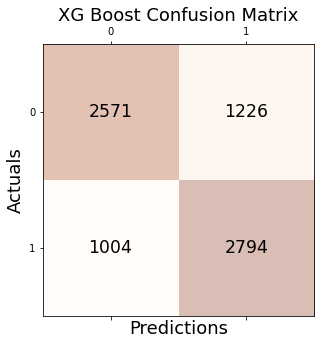

Accuracy: 0.706
Precision: 0.695
Recall: 0.736
F1 Score: 0.715
True Positives: 2794
True Negatives: 2571
False Positives: 1226
False Negatives: 1004
--------------------------------------------------
Accuracy: 0.71
Mis-Classification: 0.29
Sensitivity: 0.74
Specificity: 0.68
Precision: 0.68
f_1 Score: 0.71


In [21]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train,y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('XG Boost Confusion Matrix', fontsize=18)
plt.show()
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))


confusion_metrics(conf_matrix)

[[3719   78]
 [3752   46]]


/Users/danielshen/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


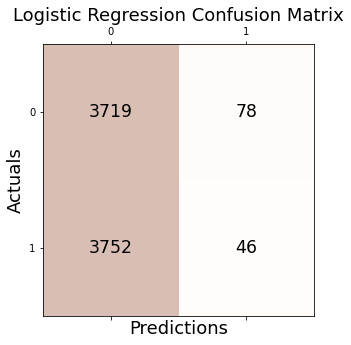

Accuracy: 0.496
Precision: 0.371
Recall: 0.012
F1 Score: 0.023
True Positives: 46
True Negatives: 3719
False Positives: 78
False Negatives: 3752
--------------------------------------------------
Accuracy: 0.5
Mis-Classification: 0.5
Sensitivity: 0.01
Specificity: 0.98
Precision: 0.98
f_1 Score: 0.02


In [22]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=0, class_weight = 'balanced').fit(X_scaled,y_train)
y_pred = lr_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Logistic Regression Confusion Matrix', fontsize=18)
plt.show()
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))


confusion_metrics(conf_matrix)

[[2421 1376]
 [1439 2359]]


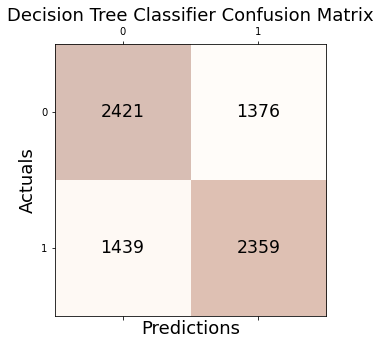

True Positives: 2359
True Negatives: 2421
False Positives: 1376
False Negatives: 1439
--------------------------------------------------
Accuracy: 0.63
Mis-Classification: 0.37
Sensitivity: 0.62
Specificity: 0.64
Precision: 0.64
f_1 Score: 0.63


In [23]:
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
dt_model = tree.DecisionTreeClassifier()
dt_model = dt_model.fit(X_train,y_train)
y_pred = dt_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Decision Tree Classifier Confusion Matrix', fontsize=18)
plt.show()
# print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
# print('Precision: %.3f' % precision_score(y_test, y_pred))
# print('Recall: %.3f' % recall_score(y_test, y_pred))
# print('F1 Score: %.3f' % f1_score(y_test, y_pred))

confusion_metrics(conf_matrix)


[[2521 1276]
 [ 917 2881]]


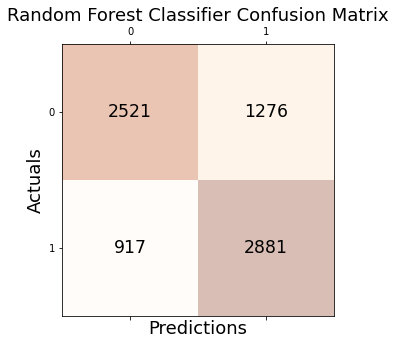

Accuracy: 0.711
Precision: 0.693
Recall: 0.759
F1 Score: 0.724
True Positives: 2881
True Negatives: 2521
False Positives: 1276
False Negatives: 917
--------------------------------------------------
Accuracy: 0.71
Mis-Classification: 0.29
Sensitivity: 0.76
Specificity: 0.66
Precision: 0.66
f_1 Score: 0.71


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
rf_model = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_model = rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Random Forest Classifier Confusion Matrix', fontsize=18)
plt.show()
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

confusion_metrics(conf_matrix)

[[2896  901]
 [2513 1285]]


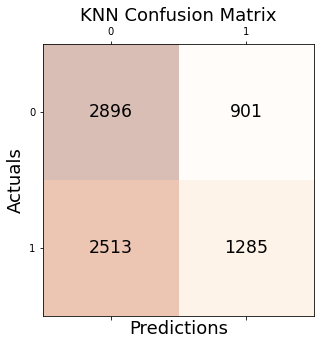

Accuracy: 0.550
Precision: 0.588
Recall: 0.338
F1 Score: 0.429
True Positives: 1285
True Negatives: 2896
False Positives: 901
False Negatives: 2513
--------------------------------------------------
Accuracy: 0.55
Mis-Classification: 0.45
Sensitivity: 0.34
Specificity: 0.76
Precision: 0.76
f_1 Score: 0.47


In [25]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh =  neigh.fit(X_train,y_train)
y_pred = neigh.predict(X_test)

print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('KNN Confusion Matrix', fontsize=18)
plt.show()
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

confusion_metrics(conf_matrix)

[[1934 1863]
 [ 712 3086]]


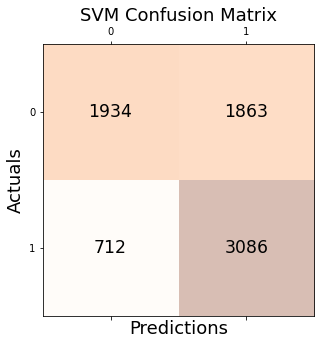

Accuracy: 0.661
Precision: 0.624
Recall: 0.813
F1 Score: 0.706
True Positives: 3086
True Negatives: 1934
False Positives: 1863
False Negatives: 712
--------------------------------------------------
Accuracy: 0.66
Mis-Classification: 0.34
Sensitivity: 0.81
Specificity: 0.51
Precision: 0.51
f_1 Score: 0.63


In [26]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
svm_model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm_model.fit(X_train,y_train)
y_pred = svm_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('SVM Confusion Matrix', fontsize=18)
plt.show()
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

confusion_metrics(conf_matrix)